In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
from torch.utils.data import DataLoader, Subset
import gzip
import os
from scipy.stats import wasserstein_distance  # EMD calculation
from collections import defaultdict, Counter
import glob
from collections import Counter
from scipy.spatial.distance import jensenshannon

### Data Partitioning


In [3]:
def load_data_from_disk(partition_id: int, only_server_test_data: bool = False):
    #save_dir = "../data/client_dataset"
    save_dir = "/content/drive/MyDrive/FYP/Implementations/dataset/client_data_set"
    BATCH_SIZE = 64

    if only_server_test_data:
        testset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
            ])
        )
        return DataLoader(testset, batch_size=BATCH_SIZE)

    client_filenames = [
        os.path.join(save_dir, f'client_{partition_id}.pt.gz'),
        os.path.join(save_dir, f'iid_clients_{partition_id}.pt.gz')
    ]
    for path in client_filenames:
        if os.path.exists(path):
            partition_data_path = path
            break
    else:
        raise FileNotFoundError(f"No data file for client {partition_id}")

    with gzip.open(partition_data_path, 'rb') as f:
        device_data = torch.load(f, map_location='cpu')
    device_data = [(x.to(torch.float32), y) for x,y in device_data]
    np.random.shuffle(device_data)
    split = int(len(device_data)*0.8)
    train_data, test_data = device_data[:split], device_data[split:]

    normalize = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    train_data = [(normalize(x), y) for x,y in train_data]
    test_data  = [(normalize(x), y) for x,y in test_data]

    trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    valloader  = DataLoader(test_data,  batch_size=BATCH_SIZE)
    return trainloader, valloader

In [4]:
# Parameters
FL_ROUNDS = 50
LOCAL_EPOCHS = 6
NUM_CLIENTS = 50

In [5]:
client_dataset_list = []
for i in range(NUM_CLIENTS):
    trainloader, valloader = load_data_from_disk(i)
    client_dataset_list.append((trainloader, valloader))

In [6]:
def get_label_distribution(trainloader, valloader):

    # Combine all labels from both train and validation sets
    all_labels = []

    for _, labels in trainloader:
        all_labels.extend(labels.tolist())

    for _, labels in valloader:
        all_labels.extend(labels.tolist())

    # Count occurrences of each class label
    label_counts = Counter(all_labels)

    # Ensure all classes are represented (0 to 9 for CIFAR-10)
    for i in range(10):
        label_counts.setdefault(i, 0)

    # Sort by label for consistency
    sorted_distribution = dict(sorted(label_counts.items()))
    return sorted_distribution


In [ ]:
for i in range(NUM_CLIENTS):
    client_id = i
    trainloader, valloader = client_dataset_list[client_id]
    distribution = get_label_distribution(trainloader, valloader)
    print(f"Label distribution for client {client_id}:", distribution)

Label distribution for client 0: {0: 0, 1: 0, 2: 0, 3: 0, 4: 555, 5: 714, 6: 0, 7: 0, 8: 0, 9: 0}
Label distribution for client 1: {0: 0, 1: 0, 2: 0, 3: 0, 4: 555, 5: 0, 6: 1000, 7: 0, 8: 0, 9: 0}
Label distribution for client 2: {0: 0, 1: 0, 2: 1000, 3: 0, 4: 0, 5: 0, 6: 0, 7: 555, 8: 0, 9: 0}
Label distribution for client 3: {0: 833, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 833, 9: 0}
Label distribution for client 4: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 714, 6: 0, 7: 0, 8: 0, 9: 1250}
Label distribution for client 5: {0: 370, 1: 199, 2: 459, 3: 107, 4: 0, 5: 0, 6: 334, 7: 408, 8: 0, 9: 0}
Label distribution for client 6: {0: 0, 1: 665, 2: 0, 3: 109, 4: 1190, 5: 232, 6: 0, 7: 39, 8: 0, 9: 0}
Label distribution for client 7: {0: 296, 1: 638, 2: 219, 3: 0, 4: 0, 5: 342, 6: 0, 7: 0, 8: 0, 9: 528}
Label distribution for client 8: {0: 173, 1: 502, 2: 424, 3: 627, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 205}
Label distribution for client 9: {0: 625, 1: 500, 2: 538, 3: 0, 4: 0, 5: 0, 6: 288, 7: 27

In [7]:
from scipy.stats import wasserstein_distance
import numpy as np

def calculate_emd(client_dist, reference_dist):
    # Ensure both distributions are sorted by label (0 through 9)
    client_counts = np.array([client_dist[i] for i in range(10)], dtype=np.float32)
    reference_counts = np.array([reference_dist[i] for i in range(10)], dtype=np.float32)

    # Normalize to create probability distributions
    client_probs = client_counts / client_counts.sum() if client_counts.sum() > 0 else np.zeros_like(client_counts)
    reference_probs = reference_counts / reference_counts.sum()

    # Label positions (as "ground distances" in 1D space)
    labels = np.arange(10)

    # Compute Earth Mover's Distance
    emd = wasserstein_distance(labels, labels, u_weights=client_probs, v_weights=reference_probs)
    return emd


In [8]:
reference_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
reference_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
reference_trainset_loader = DataLoader(reference_trainset, batch_size=64)
reference_testset_loader = DataLoader(reference_testset, batch_size=64)


reference_distribution = get_label_distribution(reference_trainset_loader, reference_testset_loader)
print(f"Label distribution for reference client:", reference_distribution)

100%|██████████| 170M/170M [00:03<00:00, 48.3MB/s]


Label distribution for reference client: {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


In [9]:
client_emd_list = []

for i in range(NUM_CLIENTS):
    trainloader, valloader = client_dataset_list[i]
    client_dist = get_label_distribution(trainloader, valloader)
    emd_value = calculate_emd(client_dist, reference_distribution)
    client_emd_list.append(emd_value)
    print(f"Client {i} EMD: {emd_value:.4f}")


Client 0 EMD: 2.0626
Client 1 EMD: 1.9862
Client 2 EMD: 1.4293
Client 3 EMD: 1.7000
Client 4 EMD: 3.0458
Client 5 EMD: 1.1446
Client 6 EMD: 1.5975
Client 7 EMD: 1.2178
Client 8 EMD: 1.9045
Client 9 EMD: 2.7341
Client 10 EMD: 1.6206
Client 11 EMD: 1.0361
Client 12 EMD: 1.4612
Client 13 EMD: 1.7131
Client 14 EMD: 1.0207
Client 15 EMD: 1.1208
Client 16 EMD: 1.9514
Client 17 EMD: 1.2979
Client 18 EMD: 1.3217
Client 19 EMD: 1.7670
Client 20 EMD: 1.5230
Client 21 EMD: 1.0383
Client 22 EMD: 1.0067
Client 23 EMD: 1.6465
Client 24 EMD: 1.5125
Client 25 EMD: 0.0956
Client 26 EMD: 0.0842
Client 27 EMD: 0.1299
Client 28 EMD: 0.0525
Client 29 EMD: 0.0381
Client 30 EMD: 0.1621
Client 31 EMD: 0.0487
Client 32 EMD: 0.1364
Client 33 EMD: 0.0705
Client 34 EMD: 0.0488
Client 35 EMD: 0.0608
Client 36 EMD: 0.0466
Client 37 EMD: 0.0531
Client 38 EMD: 0.0298
Client 39 EMD: 0.0394
Client 40 EMD: 0.0791
Client 41 EMD: 0.0708
Client 42 EMD: 0.0833
Client 43 EMD: 0.0777
Client 44 EMD: 0.0749
Client 45 EMD: 0.022

IID Clients: [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Non-IID Clients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


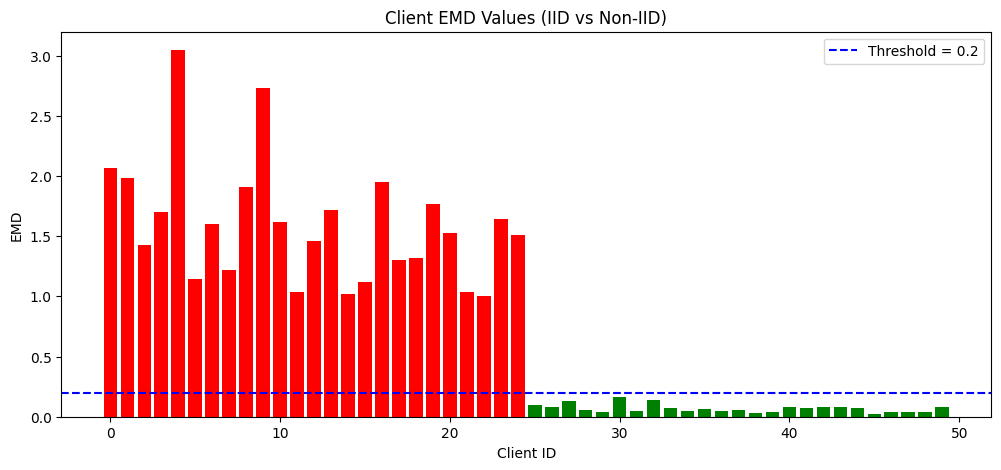

In [10]:
iid_clients = []
non_iid_clients = []

threshold = 0.2  # You can tune this

for i, emd in enumerate(client_emd_list):
    if emd <= threshold:
        iid_clients.append(i)
    else:
        non_iid_clients.append(i)

print("IID Clients:", iid_clients)
print("Non-IID Clients:", non_iid_clients)

plt.figure(figsize=(12, 5))
plt.bar(range(50), client_emd_list, color=['green' if emd <= threshold else 'red' for emd in client_emd_list])
plt.axhline(y=threshold, color='blue', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel("Client ID")
plt.ylabel("EMD")
plt.title("Client EMD Values (IID vs Non-IID)")
plt.legend()
plt.show()

In [11]:
def emd_to_weight(emd_list):
    d_min, d_max = min(emd_list), max(emd_list)
    if d_max == d_min:
        return [1.0 for _ in emd_list]  # Avoid div by zero
    return [(1 - (emd - d_min) / (d_max - d_min)) for emd in emd_list]

In [12]:
agg_emd_weight_list = emd_to_weight(client_emd_list)

for id in range(NUM_CLIENTS):
    print(f"Aggregation Weights Client {id}: " , agg_emd_weight_list[id])

Aggregation Weights Client 0:  0.32519181446354206
Aggregation Weights Client 1:  0.35048610237767985
Aggregation Weights Client 2:  0.5346885354720744
Aggregation Weights Client 3:  0.44513977216397405
Aggregation Weights Client 4:  0.0
Aggregation Weights Client 5:  0.628826596833239
Aggregation Weights Client 6:  0.47902932594336467
Aggregation Weights Client 7:  0.6046155547497525
Aggregation Weights Client 8:  0.37751547441205935
Aggregation Weights Client 9:  0.10311322060746153
Aggregation Weights Client 10:  0.47141693197366263
Aggregation Weights Client 11:  0.6647396290931538
Aggregation Weights Client 12:  0.524126307087297
Aggregation Weights Client 13:  0.44081503677619416
Aggregation Weights Client 14:  0.6698138946843226
Aggregation Weights Client 15:  0.6367108172220748
Aggregation Weights Client 16:  0.36198913872688565
Aggregation Weights Client 17:  0.5781283604080174
Aggregation Weights Client 18:  0.5702553277655686
Aggregation Weights Client 19:  0.422982320835039

## Model

In [13]:
# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 8, 8]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 128, 4, 4]
        x = x.view(-1, 128 * 4 * 4)           # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## CLient

In [14]:
class Client:

    def __init__(self, id):
        self.id = id
        #self.trainloader, self.valloader = self.load_client_dataset_from_disk(id)
        self.trainloader, self.valloader = client_dataset_list[id]

    def load_client_dataset_from_disk(self, client_id: int):
        save_dir = "/content/drive/MyDrive/Engineering-UOR/Final Year Project/Implementations/data/client_data_set"
        BATCH_SIZE = 64

        client_filenames = [
            os.path.join(save_dir, f'client_{client_id}.pt.gz'),
            os.path.join(save_dir, f'iid_clients_{client_id}.pt.gz')
        ]
        for path in client_filenames:
            if os.path.exists(path):
                partition_data_path = path
                break
        else:
            raise FileNotFoundError(f"No data file for client {client_id}")

        with gzip.open(partition_data_path, 'rb') as f:
            device_data = torch.load(f, map_location='cpu')

        device_data = [(x.to(torch.float32), y) for x, y in device_data]
        np.random.shuffle(device_data)
        split = int(len(device_data) * 0.8)
        train_data, test_data = device_data[:split], device_data[split:]

        normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        train_data = [(normalize(x), y) for x, y in train_data]
        test_data = [(normalize(x), y) for x, y in test_data]

        trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
        valloader = DataLoader(test_data, batch_size=BATCH_SIZE)
        return trainloader, valloader

    def calculate_label_distribution(self):
        all_labels = []
        for _, labels in self.trainloader:
            all_labels.extend(labels.tolist())
        for _, labels in self.valloader:
            all_labels.extend(labels.tolist())

        label_counts = Counter(all_labels)
        for i in range(10):
            label_counts.setdefault(i, 0)
        sorted_distribution = dict(sorted(label_counts.items()))
        return sorted_distribution

    def calculate_emd(self, client_dist, reference_dist):
        client_counts = np.array([client_dist[i] for i in range(10)], dtype=np.float32)
        reference_counts = np.array([reference_dist[i] for i in range(10)], dtype=np.float32)

        client_probs = client_counts / client_counts.sum() if client_counts.sum() > 0 else np.zeros_like(client_counts)
        reference_probs = reference_counts / reference_counts.sum()

        labels = np.arange(10)
        emd = wasserstein_distance(labels, labels, u_weights=client_probs, v_weights=reference_probs)
        return emd

    def calculate_js_divergence(self, client_dist, reference_dist):
        client_counts = np.array([client_dist[i] for i in range(10)], dtype=np.float32)
        reference_counts = np.array([reference_dist[i] for i in range(10)], dtype=np.float32)

        client_probs = client_counts / client_counts.sum() if client_counts.sum() > 0 else np.zeros_like(client_counts)
        reference_probs = reference_counts / reference_counts.sum()

        return jensenshannon(client_probs, reference_probs, base=2.0) ** 2

    def train_local(self, global_model, epochs, device):
        model = copy.deepcopy(global_model).to(device)
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            total_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in self.trainloader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

            avg_loss = total_loss / total
            accuracy = 100. * correct / total
            print(f"Client {self.id} Epoch {epoch + 1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

        return model.state_dict()


## Server

In [15]:
class Server:

    def __init__(self, model):
        self.model = model

    # FedAvg Algorithm
    def fed_avg(self, client_models_param_list):
        avg_params = copy.deepcopy(client_models_param_list[0])
        for key in avg_params:
            for i in range(1, len(client_models_param_list)):
                avg_params[key] += client_models_param_list[i][key]
            avg_params[key] /= len(client_models_param_list)
        return avg_params

    # Weighted FedAvg
    def weighted_fed_avg(self, models_params, weights):
        avg_params = copy.deepcopy(models_params[0])
        total_weight = sum(weights)
        for param_key in avg_params:
            weighted_sum = torch.zeros_like(avg_params[param_key])
            for i in range(len(models_params)):
                client_param = models_params[i][param_key]
                weighted_sum += client_param * weights[i]
            avg_params[param_key] = weighted_sum / total_weight
        return avg_params

    # Assign Weight For Clients based on IID nature mesures (EMD/JS/..)
    def emd_to_weights(self, client_emd_list):
        d_min, d_max = min(client_emd_list), max(client_emd_list)
        if d_max == d_min:
            return [1.0 for _ in client_emd_list]  # Avoid div by zero
        return [(1 - (emd - d_min) / (d_max - d_min)) for emd in client_emd_list]

    # Aggregation
    def aggregate_models(self, client_models, weights=None):
        if weights is None:
            print(f"\nAggregate using FedAvg.")
            aggregated_model_params = self.fed_avg(client_models)
        else:
            print(f"\nAggregate using Weighted FedAvg.")
            aggregated_model_params = self.weighted_fed_avg(client_models, weights)
        self.model.load_state_dict(aggregated_model_params)
        return self.model

    # Test Global Model
    def test_model(self, testloader, device):
        self.model.eval()
        correct, total = 0, 0
        total_loss = 0.0
        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)  # FIXED: self.model
                loss = criterion(outputs, labels)
                total_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_loss = total_loss / total
        accuracy = 100.0 * correct / total
        return accuracy, avg_loss


## Federated Training Loop

In [16]:
global_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
global_testset_loader = DataLoader(reference_testset, batch_size=64)

In [17]:
# Initialize global model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model = Net().to(device)

server = Server(global_model)

global_accuracy_list = []
global_loss_list = []

for fl_round in range(FL_ROUNDS):
    print(f"\n--- Federated Learning Round {fl_round + 1} ---")

    clients_model_param_list = []
    client_dist_list = []
    client_emd_list = []
    client_js_list = []

    for i in range(NUM_CLIENTS):

        client = Client(i)  # Load client data

        # Calculate EMD
        client_dist = client.calculate_label_distribution()
        client_emd = client.calculate_emd(client_dist, reference_distribution)
        client_js = client.calculate_js_divergence(client_dist, reference_distribution)

        client_dist_list.append(client_dist)
        client_emd_list.append(client_emd)
        client_js_list.append(client_js)



        print(f"\n Client {i}: Local Training, EMD Value: {client_emd:.4f}")
        print("--------------------------------------------------")

        # Client Local Training
        local_model_params = client.train_local(
            global_model, epochs=LOCAL_EPOCHS, device=device
        )
        clients_model_param_list.append(local_model_params)




    # Aggregation
    aggration_weight_list = server.emd_to_weights(client_emd_list=client_emd_list)
    print(f"Aggregation Weights: {aggration_weight_list}")
    server.aggregate_models(client_models=clients_model_param_list, weights=aggration_weight_list)

    # Evaluate Global Model
    accuracy, loss = server.test_model(testloader=global_testset_loader, device=device)
    global_accuracy_list.append(accuracy)
    global_loss_list.append(loss)

    print(f"\nFederated Learning Round {fl_round + 1}:")
    print(f"  Accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")


Streaming output truncated to the last 5000 lines.
Client 1 Epoch 3: Loss = 0.1268, Accuracy = 94.45%
Client 1 Epoch 4: Loss = 0.0624, Accuracy = 98.23%
Client 1 Epoch 5: Loss = 0.0295, Accuracy = 98.95%
Client 1 Epoch 6: Loss = 0.0213, Accuracy = 99.44%

 Client 2: Local Training, EMD Value: 1.4293
--------------------------------------------------
Client 2 Epoch 1: Loss = 0.3984, Accuracy = 89.31%
Client 2 Epoch 2: Loss = 0.1408, Accuracy = 95.10%
Client 2 Epoch 3: Loss = 0.0906, Accuracy = 97.11%
Client 2 Epoch 4: Loss = 0.0425, Accuracy = 98.71%
Client 2 Epoch 5: Loss = 0.0225, Accuracy = 99.20%
Client 2 Epoch 6: Loss = 0.0228, Accuracy = 99.28%

 Client 3: Local Training, EMD Value: 1.7000
--------------------------------------------------
Client 3 Epoch 1: Loss = 0.3969, Accuracy = 88.06%
Client 3 Epoch 2: Loss = 0.1839, Accuracy = 92.49%
Client 3 Epoch 3: Loss = 0.1350, Accuracy = 95.05%
Client 3 Epoch 4: Loss = 0.0767, Accuracy = 97.82%
Client 3 Epoch 5: Loss = 0.0441, Accuracy

### Plot Accuracy Curve

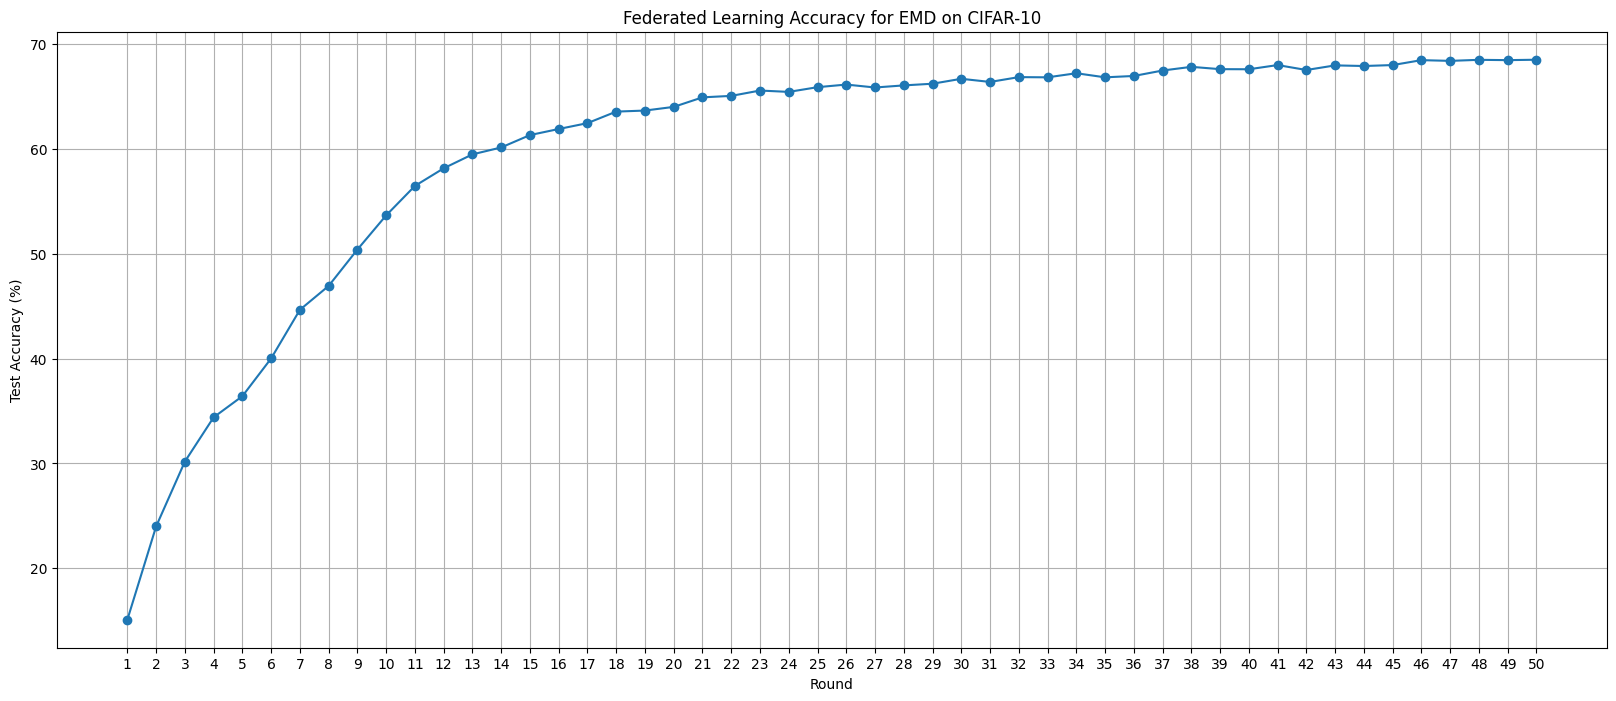

In [18]:

plt.figure(figsize=(20, 8))
plt.plot(range(1, FL_ROUNDS + 1), global_accuracy_list, marker='o')
plt.xlabel('Round')
plt.ylabel('Test Accuracy (%)')
plt.title('Federated Learning Accuracy for EMD on CIFAR-10')
plt.grid(True)
plt.xticks(range(1, 51))  # Set x-axis from 1 to 20
plt.show()

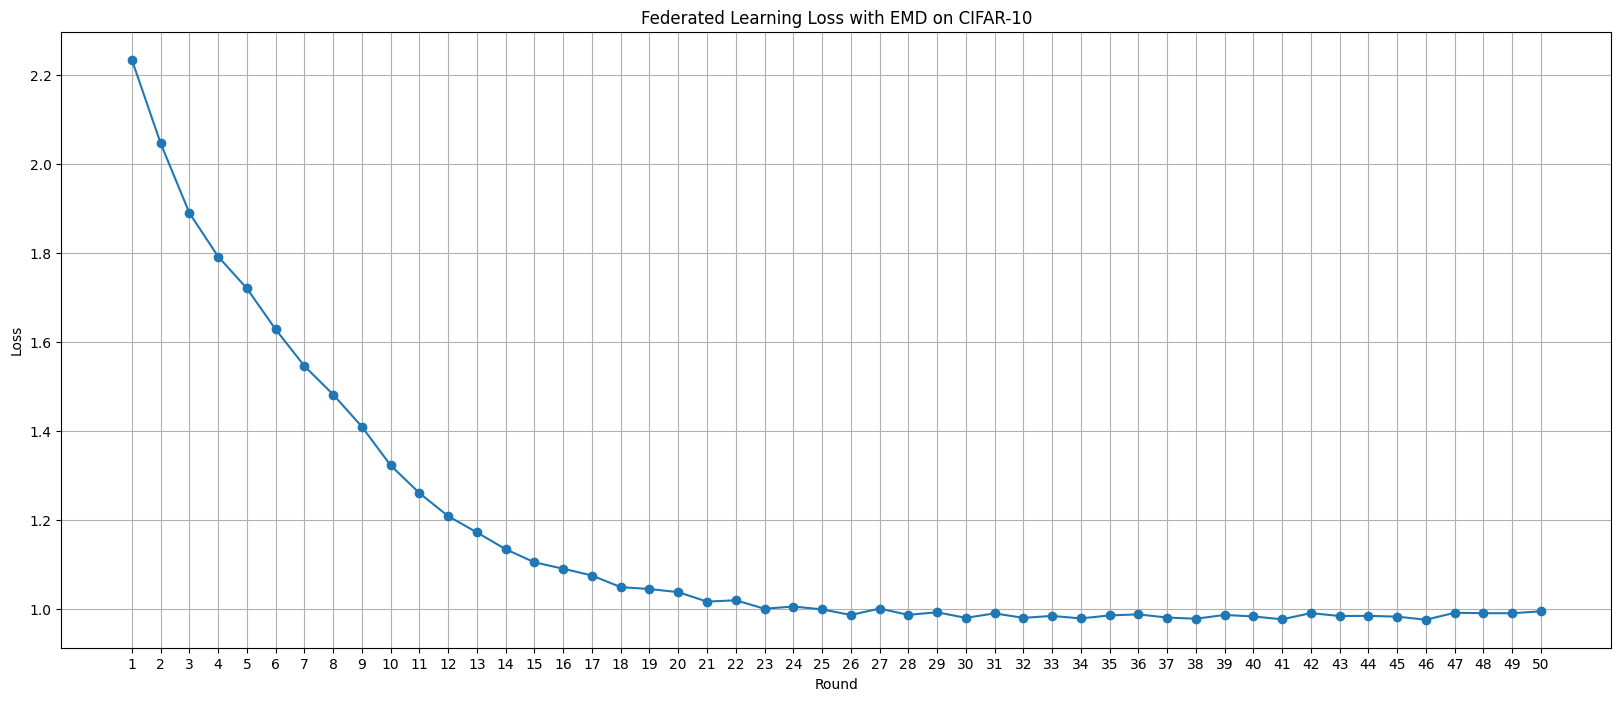

In [19]:
plt.figure(figsize=(20, 8))
plt.plot(range(1, FL_ROUNDS + 1), global_loss_list, marker='o')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Federated Learning Loss with EMD on CIFAR-10')
plt.grid(True)
plt.xticks(range(1, 51))  # Set x-axis from 1 to 20
plt.show()

In [20]:
import pickle

with open('/content/drive/MyDrive/FYP/Implementations/history/emd/accuracy_history2.pkl', 'wb') as f:
    pickle.dump(global_accuracy_list, f)

with open('/content/drive/MyDrive/FYP/Implementations/history/emd/loss_history2.pkl', 'wb') as f:
  pickle.dump(global_loss_list, f)